In [1]:
from scipy.stats import spearmanr
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import import_ipynb
from scipy.interpolate import PchipInterpolator
import seaborn as sns

In [2]:
def interpolador(subject, method, size):
    # data = np.array([int(line.strip()) for line in subject.to_numpy()])  # Si lo obtienes de un DataFrame
    data = subject
    x = np.arange(len(data))
    
    # Crear 'size' puntos equidistantes
    x_new = np.linspace(0, len(data) - 1, size*(len(data)-1) + len(data))
    
    if method == 'lineal':
        data_interp = np.interp(x_new, x, data)
    elif method == 'herm':
        interpolator = PchipInterpolator(x, data)
        data_interp = interpolator(x_new)
    
    return x_new, data_interp

In [3]:
def interpolador_constante(subject):
    # data = np.array([int(line.strip()) for line in subject.to_numpy()])  # Si lo obtienes de un DataFrame
    x = np.arange(2)
    data_interp = np.array([])
    diferencias =np.abs(np.diff(subject))
    if (np.max(diferencias) - np.min(diferencias)) <= 1e-5:
        return subject
    diferencias_sin_0 = diferencias[diferencias != 0]
    diferencias = np.round(diferencias/np.min(diferencias_sin_0))
    for i in range(len(subject)-1):
        data = subject[i:i+2]
        if diferencias[i] == 0:
            data_interp = np.concatenate((data_interp,data[:-1]))
            continue
        size = int(diferencias[i])- 1
        # Crear 'size' puntos equidistantes
        x_new = np.linspace(0, 1, size + 2)
        interp_step = np.interp(x_new, x, data)
        data_interp = np.concatenate((data_interp,interp_step[:-1]))
    data_interp = np.concatenate((data_interp,np.array([data[-1]])))

    return data_interp

In [4]:
def discretizar(array, num_partitions):
    if num_partitions == 1:
        print(" Minimo de particiones: 2")
        return np.array([])
    window = (np.abs(np.min(array)) + np.abs(np.max(array)))/(num_partitions - 1)
    discretizador = [np.min(array)+window*(i) for i in range(num_partitions)]
    if discretizador[len(discretizador)-1] != np.max(array):
        discretizador[len(discretizador)-1] = np.max(array)
    array_discreto = []
    for i,valor in enumerate(array):
        array_discreto.append(min(discretizador, key=lambda x: abs(x - valor)))

    return array_discreto

def discretizar_x(array_y, num_partitions):
    if num_partitions == 1:
        print(" Minimo de particiones: 2")
        return np.array([])
    array_x = range(int(len(array_y)))
    window = (len(array_x))/(num_partitions - 1)
    x_discreto = [int(window*(i)) for i in range(num_partitions)]
    array_discreto = []
    for i in x_discreto[0:len(x_discreto)-1]:
        array_discreto.append(array_y[i])
    array_discreto.append(array_y[len(array_x)-1])

    return x_discreto, array_discreto

In [5]:
def J_bivariante(X,Y,tau,fases):
    def distancia(p1, p2):
        return np.linalg.norm(np.array(p2)-np.array(p1))
    ff1 = np.angle(np.fft.rfft(X))[:fases]
    ff2 = np.angle(np.fft.rfft(Y))[:fases]
    vectores = []
    for i in range(len(ff1)-1):
        p1 = [ff1[i], ff2[i]]
        p2 = [ff1[i+1], ff2[i+1]]
        cuadrante = [[p2[0]-p1[0], p2[1]-p1[1]], [p2[0]-p1[0], p2[1]+2*np.pi-p1[1]],
            [p2[0]+2*np.pi-p1[0],p2[1]+2*np.pi-p1[1]],[p2[0]+2*np.pi-p1[0],p2[1]-p1[1]],
            [p2[0]+2*np.pi-p1[0],p2[1]-2*np.pi-p1[1]],[p2[0]-p1[0],p2[1]-2*np.pi-p1[1]],
            [p2[0]-2*np.pi-p1[0],p2[1]-2*np.pi-p1[1]],[p2[0]-2*np.pi-p1[0],p2[1]-p1[1]],
            [p2[0]-2*np.pi-p1[0],p2[1]+2*np.pi-p1[1]]]
        distancia1 = [distancia(p1,c) for c in cuadrante]
        p2=cuadrante[np.argmin(distancia1)]
        vectores.append([p2[0]-p1[0],p2[1]-p1[1]])
    angulos=[]
    for i in range(len(vectores)-1):
        v1=vectores[i]
        v2=vectores[i+1]
        v1_norm=v1/np.linalg.norm(v1)
        v2_norm=v2/np.linalg.norm(v2)
        angulo=np.arccos(np.clip(np.dot(v1_norm,v2_norm),-1.0,1.0))
        cruz=v1[0]*v2[1]-v1[1]*v2[0]
        if cruz>0:
            angulo=np.pi-angulo
        if cruz==0 and angulo==0:
            angulo=angulo
        if cruz==0 and angulo<0:
            angulo=np.pi
        if cruz<0:
            angulo=angulo+np.pi
        angulos.append(angulo)
    e=[]
    for k in range(len(angulos)):
        e.append(np.exp(angulos[k]*1j))
    e1=np.sum(e)/len(angulos)
    J=1.-np.abs(e1.real)
    return J

In [6]:
def J_univariante1(X,tau,fases):
    def distancia(p1, p2):
        return np.linalg.norm(np.array(p2)-np.array(p1))
    x1 = X[tau:]
    y1 = X[:-tau]
    ff1 = np.angle(np.fft.rfft(x1))[:fases]
    ff2 = np.angle(np.fft.rfft(y1))[:fases]
    
    vectores = []
    for i in range(len(ff1)-1):
        p1 = [ff1[i], ff2[i]]
        p2 = [ff1[i+1], ff2[i+1]]
        cuadrante = [[p2[0]-p1[0], p2[1]-p1[1]], [p2[0]-p1[0], p2[1]+2*np.pi-p1[1]],
            [p2[0]+2*np.pi-p1[0],p2[1]+2*np.pi-p1[1]],[p2[0]+2*np.pi-p1[0],p2[1]-p1[1]],
            [p2[0]+2*np.pi-p1[0],p2[1]-2*np.pi-p1[1]],[p2[0]-p1[0],p2[1]-2*np.pi-p1[1]],
            [p2[0]-2*np.pi-p1[0],p2[1]-2*np.pi-p1[1]],[p2[0]-2*np.pi-p1[0],p2[1]-p1[1]],
            [p2[0]-2*np.pi-p1[0],p2[1]+2*np.pi-p1[1]]]
        distancia1 = [distancia(p1,c) for c in cuadrante]
        p2 = cuadrante[np.argmin(distancia1)]
        vectores.append([p2[0]-p1[0],p2[1]-p1[1]])
    angulos = []
    for i in range(len(vectores)-1):
        v1=vectores[i]
        v2=vectores[i+1]
        if np.linalg.norm(v1) == 0:
            v1_norm=v1
        else:
            v1_norm=v1/np.linalg.norm(v1)
        if np.linalg.norm(v2) == 0:
            v2_norm=v2
        else:
            v2_norm=v2/np.linalg.norm(v2)
        angulo=np.arccos(np.clip(np.dot(v1_norm,v2_norm),-1.0,1.0))
        cruz=v1[0]*v2[1]-v1[1]*v2[0]
        if cruz>0:
            angulo=np.pi-angulo
        if cruz==0 and angulo==0:
            angulo=angulo
        if cruz==0 and angulo<0:
            angulo=np.pi
        if cruz<0:
            angulo=angulo+np.pi
        angulos.append(angulo)
    e=[]
    for k in range(len(angulos)):
        e.append(np.exp(angulos[k]*1j))
    e1=np.sum(e)/len(angulos)
    J=1.-np.abs(e1.real)
    return J

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def arm_detector(data, num_ventanas=25, b=0.6):
    n = len(data)
    x = np.arange(n)
    
    # Calcular el tamaño de cada ventana
    window_size = n // num_ventanas

    # Lista para almacenar los porcentajes de puntos dentro de las regiones
    porcentajes = []

    # Ajustar y graficar el ajuste lineal por cada ventana con las líneas paralelas
    for i in range(0, n, window_size):
        end = i + window_size
        if end > n:
            end = n
        
        x_window = x[i:end].reshape(-1, 1)
        y_window = data[i:end]
        
        # Crear y ajustar el modelo de regresión lineal
        modelo = LinearRegression()
        modelo.fit(x_window, y_window)
        
        # Obtener la pendiente y la intersección de la recta ajustada
        pendiente = modelo.coef_[0]
        interseccion = modelo.intercept_
        
        # Predecir valores ajustados
        y_pred = modelo.predict(x_window)
                
        # Calcular las rectas paralelas desplazadas por 'b'
        y_paralela_superior = pendiente * x_window + (interseccion + b)
        y_paralela_inferior = pendiente * x_window + (interseccion - b)
                
        # Calcular el porcentaje de datos dentro de la región delimitada por las líneas paralelas
        dentro_region = np.sum((y_window >= y_paralela_inferior.flatten()) & (y_window <= y_paralela_superior.flatten()))
        fuera_region = len(y_window) - dentro_region
        
        # Calcular el porcentaje de datos dentro de la región respecto a los datos fuera de la región
        porcentaje = (dentro_region * 100)/(dentro_region + fuera_region)
        porcentajes.append(porcentaje)

    def indice_mayor_90(arr):
        n = len(arr)
    
        # Revisar cada índice para encontrar el primero que cumpla la condición
        for i in range(n):
            if np.all(arr[i:] > 80) and len(arr[i:]) > 4:
                return i
        # Si no hay tal índice, regresar el último índice
        return n - 1
    
    indice = indice_mayor_90(np.array(porcentajes))*window_size
    return indice

def J_univariante(X,tau, corte):
    def distancia(p1, p2):
        return np.linalg.norm(np.array(p2)-np.array(p1))
    x1 = X[tau:]
    y1 = X[:-tau]
    ff1 = np.angle(np.fft.rfft(x1))
    ff2 = np.angle(np.fft.rfft(y1))
    if corte:
        # print(len(ff1),len(ff2))
        transition_point1 = arm_detector(ff1)
        transition_point2 = arm_detector(ff2)
        if transition_point1 != transition_point2:
            transition_point1 = transition_point2 = min(transition_point1, transition_point2)
        ff2 = ff2[:transition_point2]
        ff1 = ff1[:transition_point1]
        # print(len(ff1),len(ff2))
    vectores = []
    for i in range(len(ff1)-1):
        p1 = [ff1[i], ff2[i]]
        p2 = [ff1[i+1], ff2[i+1]]
        cuadrante = [[p2[0]-p1[0], p2[1]-p1[1]], [p2[0]-p1[0], p2[1]+2*np.pi-p1[1]],
            [p2[0]+2*np.pi-p1[0],p2[1]+2*np.pi-p1[1]],[p2[0]+2*np.pi-p1[0],p2[1]-p1[1]],
            [p2[0]+2*np.pi-p1[0],p2[1]-2*np.pi-p1[1]],[p2[0]-p1[0],p2[1]-2*np.pi-p1[1]],
            [p2[0]-2*np.pi-p1[0],p2[1]-2*np.pi-p1[1]],[p2[0]-2*np.pi-p1[0],p2[1]-p1[1]],
            [p2[0]-2*np.pi-p1[0],p2[1]+2*np.pi-p1[1]]]
        distancia1 = [distancia(p1,c) for c in cuadrante]
        p2 = cuadrante[np.argmin(distancia1)]
        vectores.append([p2[0]-p1[0],p2[1]-p1[1]])
    angulos = []
    for i in range(len(vectores)-1):
        v1=vectores[i]
        v2=vectores[i+1]
        if np.linalg.norm(v1) == 0:
            v1_norm = v1
        else:
             v1_norm=v1/np.linalg.norm(v1)
        if np.linalg.norm(v2) == 0:
            v2_norm = v2
        else:
            v2_norm=v2/np.linalg.norm(v2)
        angulo=np.arccos(np.clip(np.dot(v1_norm,v2_norm),-1.0,1.0))
        cruz=v1[0]*v2[1]-v1[1]*v2[0]
        if cruz>0:
            angulo=np.pi-angulo
        if cruz==0 and angulo==0:
            angulo=angulo
        if cruz==0 and angulo<0:
            angulo=np.pi
        if cruz<0:
            angulo=angulo+np.pi
        angulos.append(angulo)

    e=[]
    for k in range(len(angulos)):
        e.append(np.exp(angulos[k]*1j))
    e1=np.sum(e)/len(angulos)
    J=1.-np.abs(e1.real)
    return J, angulos

In [9]:
def J_univariante(X, tau, corte):
    def distancia(p1, p2):
        return np.linalg.norm(np.array(p2) - np.array(p1))
    X = np.array(X)
    x1 = X[tau:]
    y1 = X[:-tau]
    ff1 = np.angle(np.fft.rfft(x1))
    ff2 = np.angle(np.fft.rfft(y1))
    
    if corte:
        transition_point1 = arm_detector(ff1)
        transition_point2 = arm_detector(ff2)
        if transition_point1 != transition_point2:
            transition_point1 = transition_point2 = min(transition_point1, transition_point2)
        ff1 = ff1[:transition_point1]
        ff2 = ff2[:transition_point2]

    vectores = []
    for i in range(len(ff1) - 1):
        p1 = [ff1[i], ff2[i]]
        p2 = [ff1[i + 1], ff2[i + 1]]
        cuadrante = [
            [p2[0] - p1[0], p2[1] - p1[1]],
            [p2[0] - p1[0], p2[1] + 2 * np.pi - p1[1]],
            [p2[0] + 2 * np.pi - p1[0], p2[1] + 2 * np.pi - p1[1]],
            [p2[0] + 2 * np.pi - p1[0], p2[1] - p1[1]],
            [p2[0] + 2 * np.pi - p1[0], p2[1] - 2 * np.pi - p1[1]],
            [p2[0] - p1[0], p2[1] - 2 * np.pi - p1[1]],
            [p2[0] - 2 * np.pi - p1[0], p2[1] - 2 * np.pi - p1[1]],
            [p2[0] - 2 * np.pi - p1[0], p2[1] - p1[1]],
            [p2[0] - 2 * np.pi - p1[0], p2[1] + 2 * np.pi - p1[1]],
        ]
        distancias = np.array([distancia(p1, c) for c in cuadrante])
        p2 = cuadrante[np.argmin(distancias)]
        vectores.append([p2[0] - p1[0], p2[1] - p1[1]])

    vectores = np.array(vectores)
    norms = np.linalg.norm(vectores, axis=1, keepdims=True)
    v_norm = np.where(norms == 0, vectores, vectores / norms)
    
    angulos = np.arccos(np.clip(np.einsum('ij,ij->i', v_norm[:-1], v_norm[1:]), -1.0, 1.0))
    cruces = np.cross(v_norm[:-1], v_norm[1:])
    angulos = np.where(cruces > 0, np.pi - angulos, angulos)
    angulos = np.where((cruces == 0) & (angulos < 0), np.pi, angulos)
    angulos = np.where(cruces < 0, angulos + np.pi, angulos)

    e = np.exp(angulos * 1j)
    e1 = np.sum(e) / len(angulos)
    J = 1.0 - np.abs(e1.real)
    
    return J, angulos


1000
1000
(0.7267414448139675, array([5.24373954e-03, 3.16991420e+00, 3.07747153e+00, 3.11636596e+00,
       3.13521349e+00, 3.13734299e+00, 6.23890269e+00, 3.14417516e+00,
       3.14373763e+00, 3.14299154e+00, 3.14279294e+00, 3.14348274e+00,
       3.14003632e+00, 3.14408022e+00, 3.13987522e+00, 3.14597854e+00,
       3.14120792e+00, 3.14190315e+00, 3.14148110e+00, 3.14604428e+00,
       3.13818794e+00, 3.13926048e+00, 3.13920409e+00, 3.14192018e+00,
       3.15176069e+00, 3.13031378e+00, 3.14253929e+00, 3.14311384e+00,
       3.17056881e+00, 3.10409279e+00, 3.16841256e+00, 3.11102321e+00,
       3.15553796e+00, 3.13836495e+00, 3.16009318e+00, 3.10717492e+00,
       3.16514893e+00, 3.15795472e+00, 3.12867605e+00, 3.10462464e+00,
       3.18098095e+00, 3.13002145e+00, 3.13577114e+00, 3.15081314e+00,
       3.14046559e+00, 3.10959496e+00, 3.22426588e+00, 3.03993287e+00,
       3.24463900e+00, 3.07684925e+00, 3.13349066e+00, 3.16726397e+00,
       3.13033795e+00, 3.14413627e+00, 3.13225

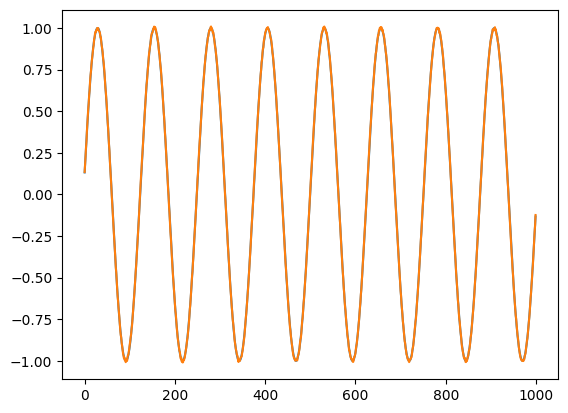

In [10]:
def generar_uniforme_centrada(n, varianza):
    # Calcular el límite superior e inferior de la distribución uniforme
    limite = np.sqrt(varianza) # varianza*3
    # Generar n números aleatorios con distribución uniforme entre -limite y limite
    return np.random.uniform(-limite, limite, n)
afa = [np.sin(x) for x in np.linspace(-25,25,1000)]
plt.plot(afa)
ri = afa + generar_uniforme_centrada(len(afa),0.0001)
print(len(ri))
print(len(afa))
plt.plot(ri)
print(J_univariante(ri, 1, len(ri)))

ruido = generar_uniforme_centrada(1, 0.00001)
print(ruido[0])

In [11]:


def lyapunov_exponent_from_orbit(orbit, r):
    lyapunov_sum = 0

    for x in orbit:
        # Derivada de la función logística
        derivative = abs(r * (1 - 2 * x))
        if derivative == 0:
            lyapunov_sum += 0
        else:
            lyapunov_sum += np.log(derivative)

    # Calcular el exponente de Lyapunov
    lyapunov_exponent = lyapunov_sum / len(orbit)
    return lyapunov_exponent


In [12]:
def brownian_bridge(t0, tT, x0, xT, n_steps):
    t = np.linspace(t0, tT, n_steps)
    #Generar movimiento browniano con media cero
    W = np.random.normal(0, np.sqrt(t[1] - t[0]), size=n_steps-1)
    W = np.insert(np.cumsum(W), 0, 0)  # Inserta W(0) = 0 y suma acumulativa
    # Interpolación del Brownian Bridge
    X = x0 + (t - t0) / (tT - t0) * (xT - x0) + W - (t - t0) / (tT - t0) * W[-1]
    return t, X

def interpolador_estocastico(s_0_discreto, n_steps):
    t_list, X_list = [], []
    for i in range(len(s_0_discreto)- 1):
        t0 = i
        tT = i+1
        x0 = s_0_discreto[i]
        xT = s_0_discreto[i+1]
        t, X = brownian_bridge(t0, tT, x0, xT, n_steps)
        t_list = np.concatenate((t_list, t))
        X_list = np.concatenate((X_list, X))
    return X_list

In [13]:
def graficar_angulos_en_circulo(angulos):
    # Crear una figura y un set de ejes
    fig, ax = plt.subplots(subplot_kw={'aspect': 'equal'})
    
    # Dibujar el círculo unitario
    circulo = plt.Circle((0, 0), 1, color='blue', fill=False, linestyle='--')
    ax.add_artist(circulo)

    # Coordenadas del círculo unitario
    x_circulo = np.cos(np.linspace(0, 2 * np.pi, 100))
    y_circulo = np.sin(np.linspace(0, 2 * np.pi, 100))
    ax.plot(x_circulo, y_circulo, 'b--')  # Línea del círculo

    # Graficar los puntos correspondientes a los ángulos en el círculo unitario
    for angulo in angulos:
        x = np.cos(angulo)
        y = np.sin(angulo)
        ax.plot([0, x], [0, y], color='gray', linestyle='--')  # Línea desde el origen
        ax.plot(x, y, 'ro')  # Punto en el círculo

    # Ajustes del gráfico
    ax.set_xlim([-1.2, 1.2])
    ax.set_ylim([-1.2, 1.2])
    ax.set_xlabel('Eje X')
    ax.set_ylabel('Eje Y')
    ax.set_title('Ángulos en el círculo unitario')
    
    # Dibujar los ejes
    ax.axhline(0, color='black',linewidth=0.5)
    ax.axvline(0, color='black',linewidth=0.5)

    # Mantener proporciones iguales
    ax.set_aspect('equal')
    plt.grid(True)
    plt.show()


In [136]:
J_min = np.load('J_minus_continuo.npy')
J_min[1,np.where(J_min[0,:] == 22955//2)]

array([[0.98310495]])

Interpolación
Dinámica simbólica
22955 3.0033444816053514
22955 3.0066889632107023
22955 3.0100334448160537
22955 3.0133779264214047
22955 3.016722408026756
22955 3.020066889632107
22955 3.0234113712374584
22955 3.0267558528428093
22955 3.0301003344481607
22955 3.0334448160535117
22955 3.036789297658863
22955 3.040133779264214
22955 3.0434782608695654
22955 3.0468227424749164
22955 3.0501672240802677
22955 3.0535117056856187
22955 3.05685618729097
22955 3.060200668896321
22955 3.0635451505016724
22955 3.0668896321070234
22955 3.0702341137123748
22955 3.0735785953177257
22955 3.076923076923077
22955 3.080267558528428
22955 3.0836120401337794
22955 3.0869565217391304
22955 3.0903010033444818
22955 3.0936454849498327
22955 3.096989966555184
22955 3.100334448160535
22955 3.1036789297658864
22955 3.1070234113712374
22955 3.1103678929765888
22955 3.1137123745819397
22955 3.117056856187291
22955 3.120401337792642
22955 3.1237458193979935
22955 3.1270903010033444
22955 3.130434782608696
22955 

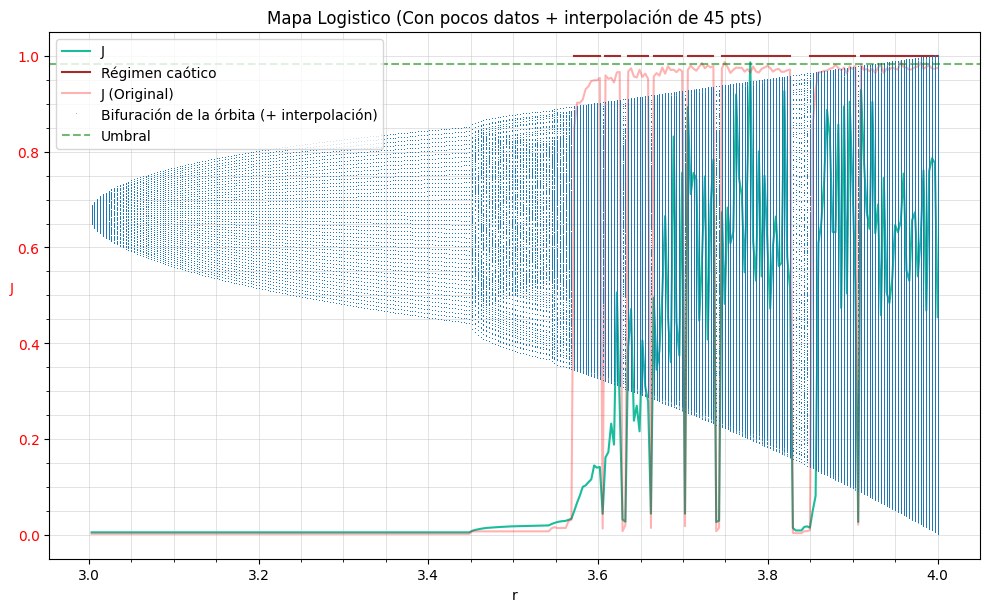

Correlación de Spearman: 0.9158099332654263


In [137]:
"""interpolacion despues de dinamica simbolica"""


def logistic_map(r, x):
    return r * x * (1 - x)

def plot_orbit_diagram(num_partitions,discreto,interpolacion, size,graficar, r_min = 3.0, r_max = 4.0, num_points_per_r=300,
 num_iterations_discard=3000, num_iterations_display=500):
    if discreto == "no" and interpolacion == "si": 
        print("Haz seleccionado interpolación a los datos continuos, eso no tiene caso")
        return 1,2
    # J_continuo = np.load('logistic_map/j_logistic_continuo.npy')
    J_continuo = np.load('logistic_map/J_OG_muchosdatos.npy')
    if interpolacion == "si":
        print("Interpolación")

    r_values = []
    orbit_values = []
    
    for r in np.linspace(r_min, r_max, num_points_per_r):
        if r == 3.0:
            continue
        x = 0.6
        for _ in range(num_iterations_discard): # Converger
            # x = np.clip(x, 0.0, 1.0)
            x = logistic_map(r, x) #+ generar_uniforme_centrada(1, 1e-6)[0]
        for _ in range(num_iterations_display):
            # x = np.clip(x, 0.0, 1.0)
            x = logistic_map(r, x) #+ generar_uniforme_centrada(1, 1e-6)[0]
            r_values.append(r)
            orbit_values.append(x)
        
    #A partir de aqui, orbita continua de logistica completada
    if discreto == "si":
        print('Dinámica simbólica')
        # orbit_values = discretizar(orbit_values, num_partitions )
        
    a = 0
    J_values=[]
    # cambios = []
    J_index=[]
    caotico = np.load('logistic_map/regimen_caotico.npy')
    lyapunov_values = []
    b=0
    
    r_values_interp = []
    orbit_values_interp = np.array([])
    ti, to = True, True
    for i in range(0, len(r_values) - 1):
        if r_values[i] != r_values[i+1]:
            r_single_orbit = orbit_values[a:i+1]
            if periodos_logistic[b] != "Caos":
                r_single_orbit = r_single_orbit[:2000]
            a = i+1

            if interpolacion == 'si':
                # if not np.isnan(caotico[b]):
                #     print(caotico[b])
                #     r_single_orbit = remove_consecutive_duplicates(r_single_orbit)
                x = np.arange(len(r_single_orbit))
                x_new, data_interp = interpolador(r_single_orbit, 'lineal', 45)
                # data_interp = interpolador_constante(r_single_orbit)
                # data_interp = interpolador_estocastico(data_interp, 3)
                # data_interp = r_single_orbit
                # data_interp = data_interp + generar_uniforme_centrada(len(data_interp),1e-6)
                r_values_interp = r_values_interp + [r_values[i]]*len(data_interp)
                orbit_values_interp = np.concatenate((orbit_values_interp, data_interp))

                r_single_orbit = data_interp

            lyapunov = lyapunov_exponent_from_orbit(r_single_orbit, r_values[i])
            lyapunov_values.append(lyapunov)
            print(len(r_single_orbit),r_values[i])
            J, angulos = J_univariante(r_single_orbit, 1, False)
            J_values.append(J)
            # cambios.append(intensidad_cambios(r_single_orbit))
            # print(r_values[i], J_continuo[len(J_values)-1],J, np.min(r_single_orbit))
            J_index.append(r_values[i])
            b += 1
    #ultimo valor de r
    lyapunov = lyapunov_exponent_from_orbit(orbit_values[a:], r_values[len(r_values) - 1])  
    lyapunov_values.append(lyapunov)
    r_single_orbit = orbit_values[a:]
    if interpolacion == 'si':
        r_single_orbit = remove_consecutive_duplicates(r_single_orbit)
        x = np.arange(len(orbit_values[a:]))
        x_new, data_interp = interpolador(orbit_values[a:], 'lineal', 45)
        # data_interp = interpolador_constante(orbit_values[a:])
        # data_interp = interpolador_estocastico(data_interp, 3)
        # data_interp = orbit_values[a:]
        # data_interp = data_interp + generar_uniforme_centrada(len(data_interp), 1e-6)
        r_values_interp = r_values_interp + [r_values[i]]*len(data_interp)
        orbit_values_interp = np.concatenate((orbit_values_interp, data_interp))
        r_single_orbit = data_interp
    
    J = J_univariante(r_single_orbit, 1, False)[0]
    J_values.append(J)
    J_index.append(r_values[len(r_values) - 1])
    # cambios.append(intensidad_cambios(r_single_orbit))
    # J_values = np.load('logistic_map/J_interp_lineal_15pts_muchosdatos.npy')
    #A partir de aqui, lyapunob y J fueron calculados
    

    if graficar == True:
        fig, ax1 = plt.subplots(figsize=(10,6))
        
        if discreto == "no":
            color = "red"
        elif discreto == "si":
            color = '#1ABC9C'
    
        ax1.plot(J_index, J_values, color=color, label='J' , alpha = 1)
        # ax1.axhline(y = 0.96, lw=0.5)
        ax1.plot(J_index, np.array(caotico), color ='brown',linestyle='-', label = 'Régimen caótico')
        if discreto == "si":
            ax1.plot(J_index, J_continuo, 'red',label='J (Original)', alpha = 0.3)
            if interpolacion == "si":
                ax1.plot(r_values_interp, orbit_values_interp, ',', label=f'Bifuración de la órbita (+ interpolación)', alpha=0.5)
            else: 
                ax1.plot(r_values, orbit_values, ',', label='Bifuración de la órbita (10 bines)', alpha=1)
        if discreto == "no":
            ax1.plot(r_values, orbit_values, ',', label='Bifurcación de la órbita', alpha=1)
        ax1.set_xlabel('r')
        ax1.axhline(y=0.9831, color='green', linestyle='--', alpha =0.55,label='Umbral')
        ax1.set_ylabel('J', color='r', rotation = 360)
        ax1.tick_params(axis='y', labelcolor='r')
        # ax1.set_ylim(0,1)
        ax1.legend(loc = 'upper left')
        
        major_ticks_x = np.linspace(3, 4, 6)  # 0.0, 0.2, ..., 1.0
        minor_ticks_x = np.linspace(3, 4, 21)  # Ticks secundarios

        major_ticks_y = np.linspace(0, 1, 6)  # -1, -0.5, 0, 0.5, 1.0
        minor_ticks_y = np.linspace(0, 1, 21)  # Ticks secundarios

        # Configurar los ticks del eje X
        plt.xticks(major_ticks_x)  # Solo etiquetar los ticks principales
        plt.gca().set_xticks(minor_ticks_x, minor=True)  # Agregar ticks menores sin etiquetas

        # Configurar los ticks del eje Y
        plt.yticks(major_ticks_y)  # Solo etiquetar los ticks principales
        plt.gca().set_yticks(minor_ticks_y, minor=True)  # Agregar ticks menores sin etiquetas

        # Activar la cuadrícula
        plt.grid(which='major', linestyle='-', linewidth=0.5, alpha=0.5)  # Para ticks principales
        plt.grid(which='minor', linestyle='-', linewidth=0.5, alpha=0.5)         

        if discreto == "no":
            ax2 = ax1.twinx()
            ax2.axhline(y=0, color='black', linestyle='--', alpha =0.55)
            ax2.plot(J_index, lyapunov_values, 'black', label = 'λ')
            ax2.set_ylabel('λ', color='black', rotation = 360)
            ax2.tick_params(axis='y', labelcolor='black')
            ax2.legend(loc='center right',framealpha=0.5)
        
        fig.tight_layout()  
        # plt.title(f'Logistic Map (Discret ={discreto}, interp= {interpolacion})')
        # plt.title(f'Mapa Logístico con discretización en el eje y ({num_partitions} Particiones)')
        plt.title(f'Mapa Logistico (Ruido aditivo)')
        plt.show()
        caotico = np.array(caotico)
        J_values = np.array(J_values)
        # cambios = np.array(cambios)
        # correlacion, p_valor = spearmanr(J_values[np.isnan(caotico)], cambios[np.isnan(caotico)])
        # print(f'Correlación de Spearman1: {correlacion}')

    if interpolacion == 'no':
        return J_index, J_values, r_values, orbit_values, lyapunov_values
    else:
        return J_index, J_values, r_values_interp, orbit_values_interp, lyapunov_values 


# with open('logistic_map/lyapunov_continuo.txt', 'r') as f:
#         lyapunov_continuo = [float(line.strip()) for line in f]

J_continuo = np.load('logistic_map/J_OG_muchosdatos.npy')
# J_continuo = np.load('logistic_map/j_logistic_continuo.npy')

J_index, J_values, r_values, orbit_values, lyapunov_values = plot_orbit_diagram(10,"si","si", 20 ,True)
# J_index, J_values, r_values, orbit_values, lyapunov_values_continuo = plot_orbit_diagram(50,"no", "no", 20 ,True)

# 0.879212493840967 15 lineal
# Calcular correlación de Spearman
correlacion, p_valor = spearmanr(J_values, J_continuo)

print(f'Correlación de Spearman: {correlacion}')

# np.save('J_continuo_2_5.npy', np.array(J_values))

In [64]:
np.save('logistic_map/J_OG_muchosdatos.npy',J_values)

In [625]:
import os
carpeta = r'logistic_map/ruidos_promedios_iterado'
archivos_en_carpeta = os.listdir(carpeta)

for archivo in archivos_en_carpeta:
    if 'J_por_ruido' in archivo:
        ruido = archivo[12:]
    else: 
        continue
    varianza = np.mean(np.load(carpeta+'/varianza_por_ruido_'+str(ruido)),axis=0)
    J = np.mean(np.load(carpeta+'/J_por_ruido_'+str(ruido)),axis=0)
    correlacion, p_valor = spearmanr(varianza[~np.isnan(varianza)], J[~np.isnan(varianza)])
    print(f'Correlación de Spearman: {correlacion}, {ruido}')


Correlación de Spearman: 0.16665639267207336, 0.0001.npy
Correlación de Spearman: 0.674964843674751, 1e-05.npy
Correlación de Spearman: 0.9437402477316946, 1e-06.npy
Correlación de Spearman: 0.5607019706805879, 1e-07.npy
Correlación de Spearman: 0.49827589528231003, 1e-08.npy
Correlación de Spearman: 0.4656932056789505, 1e-10.npy
Correlación de Spearman: 0.29961857795072333, 2e-05.npy
Correlación de Spearman: 0.2298857660226156, 3e-05.npy
Correlación de Spearman: 0.19641694438558305, 4e-05.npy


In [14]:
def replace_long_repeating_segments(data, tolerance=1e-1):
    """
    Reemplaza segmentos largos de valores repetidos en los datos con un puente browniano,
    permitiendo un margen de tolerancia para determinar si los valores son similares.
    
    Args:
        data (list or array): Array de datos a procesar.
        tolerance (float): Margen de tolerancia para considerar valores como repetidos.
        
    Returns:
        list: Array con los segmentos largos reemplazados por un puente browniano.
    """
    result = []
    n = len(data)
    i = 0
    
    while i < n:
        start = i
        # Detectar si hay un segmento repetido dentro del margen de tolerancia
        while i < n - 1 and abs(data[i] - data[i + 1]) <= tolerance:
            i += 1
        
        segment_length = i - start + 1
        
        if segment_length > 2:  # Si el segmento tiene más de dos puntos repetidos
            result.append(data[start])  # Mantener el primer valor
            x0 = data[start]
            xT = data[i]
            t0, tT = 0, 1  # Intervalo estándar para el puente browniano
            
            # Generar los puntos interpolados con el puente browniano
            _, bridge = brownian_bridge(t0, tT, x0, xT, segment_length)
            result.extend(bridge[1:-1])  # Añadir los puntos generados (sin el primero ni el último)
            result.append(data[i])  # Mantener el último valor
        else:
            # Si hay uno o dos puntos repetidos, se añaden tal como están
            result.extend(data[start:i + 1])
        
        i += 1
    
    return result

In [15]:
def remove_consecutive_duplicates(data, tolerance=1e-1):
    """
    Remueve duplicados consecutivos en los datos con un margen de tolerancia.

    Args:
        data (list or array): Array de datos a procesar.
        tolerance (float): Margen de tolerancia para considerar valores similares.

    Returns:
        list: Array con duplicados consecutivos removidos.
    """
    if not data:
        return []

    result = [data[0]]  # Comenzamos con el primer elemento
    for i in range(1, len(data)):
        if abs(data[i] - data[i - 1]) > tolerance:
            result.append(data[i])

    return np.array(result)
remove_consecutive_duplicates([5,2.35,2.36,2.39,2.49,4])

array([5.  , 2.35, 2.49, 4.  ])

mean 0.09481945247398282
m index 0.7697088647475643
J 0.751461584524091


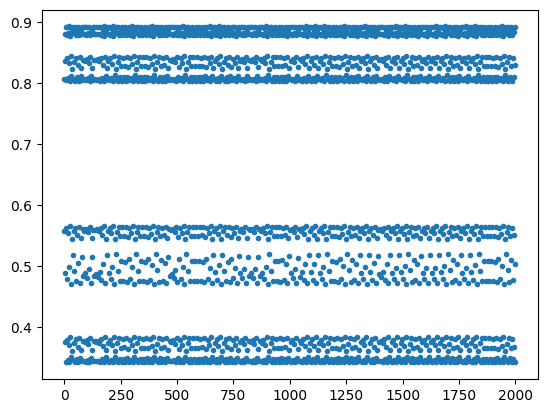

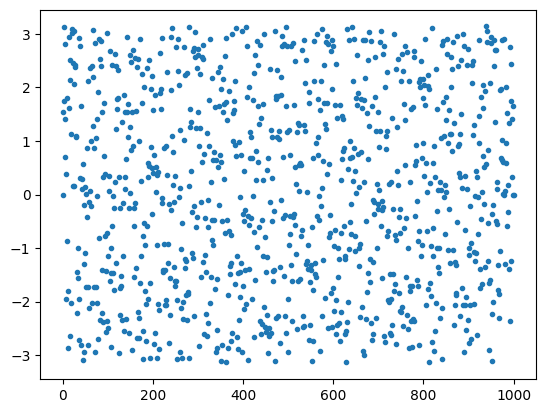

J_interp 0.2066955702768527


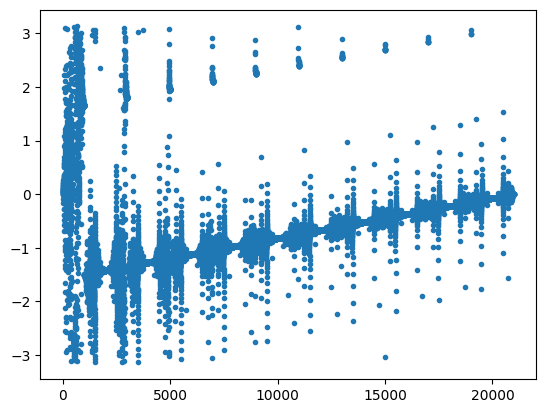

In [620]:
orbit_values = []
# J_diff, index = [], []
# r = 3.759197324414716 # no le afecta
# r = 3.6989966555183944 
# r = 3.9899665551839467
# r = 3.8963210702341136 
# r = 3.625418060200669 
# r = 3.819397993311037  # le afecta 
r = 3.57190635451505 
x = 0.6
for _ in range(3000): # Converger
    # x = np.clip(x, 0.0, 1.0)
    x = logistic_map(r, x) #+ generar_uniforme_centrada(1, 1e-6)[0]
for _ in range(2000):
    # x = np.clip(x, 0.0, 1.0)
    x = logistic_map(r, x) #+ generar_uniforme_centrada(1, 1e-6)[0]
    orbit_values.append(x)
# orbit_values = generar_uniforme_centrada(2000,1e-6)
# orbit_values = np.clip(replace_long_repeating_segments(orbit_values),0.2,0.9)
orbit_values = remove_consecutive_duplicates(orbit_values)
plt.plot(orbit_values,marker='.', ls = '')
print('mean',intensidad_cambios(orbit_values))
print('m index',J_univariante(derivada_index(orbit_values),1,False)[0])
J_faf,ang = J_univariante(orbit_values,1,False)
print('J', J_faf)
plt.show()
plt.plot(np.angle(np.fft.rfft(orbit_values)),'.')
plt.show()
orbit_values = interpolador(orbit_values, 'lineal',20)[1]
# plt.xlim(0,200)
plt.plot(np.angle(np.fft.rfft(orbit_values)),'.')
J_interp = J_univariante(orbit_values,1,True)[0]
print('J_interp',J_interp)
# index.append(intensidad_cambios(orbit_values))
# J_diff.append(J_faf - J_interp)

In [16]:
import numpy as np

def derivada_index(array):
    array = np.asarray(array)
    derivada = np.abs(np.diff(array))  # Calcula la diferencia entre puntos subsecuentes
    return derivada

In [164]:
correlacion, p_valor = spearmanr(J_diff, index)

print(f'Correlación de Spearman: {correlacion}')

Correlación de Spearman: -0.3571428571428572


In [17]:
import numpy as np

def mean_d(array):
    distancias = np.abs(np.diff(array))
    return np.mean(distancias)


In [18]:
import numpy as np

def intensidad_cambios(array):
    distancias = np.abs(np.diff(array))  # Distancias entre puntos subsecuentes
    cambios = np.diff(distancias)       # Cambios en las distancias
    return np.std(distancias)              # Desviación estándar de los cambios

# Ejemplo de uso
array = [220, 230, 255, 300, 274, 296, 245, 256]
array = [10, 13, 16, 10, 15]
print(intensidad_cambios(array))  # Muestra la intensidad de los cambios abruptos


1.299038105676658


In [56]:
# Cargar la lista desde un archivo .txt
periodos_logistic = []
with open("logistic_map\periodos_logistic.txt", "r") as file:
    for line in file:
        # Convertir cada línea a su tipo adecuado (número o cadena)
        line = line.strip()  # Eliminar saltos de línea o espacios extra
        if line.replace(".", "", 1).isdigit():  # Verifica si es un número (enteros o flotantes)
            if "." in line:
                periodos_logistic.append(float(line))  # Si tiene punto, es flotante
            else:
                periodos_logistic.append(int(line))  # Si no, es entero
        else:
            periodos_logistic.append(line)  # Si no es número, es una cadena

# Ver la lista cargada
print(periodos_logistic)


[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 8, 8, 8, 8, 8, 8, 16, 16, 'Caos', 'Caos', 'Caos', 'Caos', 'Caos', 'Caos', 'Caos', 'Caos', 'Caos', 'Caos', 10, 'Caos', 'Caos', 'Caos', 'Caos', 'Caos', 'Caos', 6, 12, 'Caos', 'Caos', 'Caos', 'Caos', 'Caos', 'Caos', 'Caos', 'Caos', 8, 'Caos', 'Caos', 'Caos', 'Caos', 'Caos', 'Caos', 'Caos', 'Caos', 'Caos', 'Caos', 'Caos', 14, 'Caos', 'Caos', 'Caos', 'Caos', 'Caos', 'Caos', 'Caos', 'Caos', 'Caos', 'Caos', 5, 10, 'Caos', 'Caos', 'Caos', 'Caos', 'Caos', 'Caos', 'Caos', 'Caos', 'Caos', 'Caos', 'Caos', 'Caos', 'Caos'

array([ 2.21338217e-004,  5.15675452e-006,  7.32577432e-008,
        8.08101309e-010,  7.48124375e-012,  6.00918207e-014,
        4.25740639e-016,  2.68369825e-018,  1.51198023e-020,
        7.62922421e-023,  3.44945004e-025,  1.39667862e-027,
        5.05726973e-030,  1.63431272e-032,  4.70173827e-035,
        1.20060281e-037,  2.71205420e-040,  5.39925492e-043,
        9.43468071e-046,  1.44060234e-048,  1.91289981e-051,
        2.19743693e-054,  2.17165918e-057,  1.83532806e-060,
        1.31791577e-063,  7.98572845e-067,  4.05299059e-070,
        1.70928409e-073,  5.93903003e-077,  1.68454474e-080,
        3.86197931e-084,  7.08032925e-088,  1.02611368e-091,
        1.16092921e-095,  1.01157105e-099,  6.68914432e-104,
        3.30341643e-108,  1.19721883e-112,  3.12381355e-117,
        5.74612961e-122,  7.28129379e-127,  6.19598053e-132,
        3.44206680e-137,  1.20980315e-142,  2.59779732e-148,
        3.27703014e-154,  2.32385068e-160,  8.81388991e-167,
        1.68965453e-173,

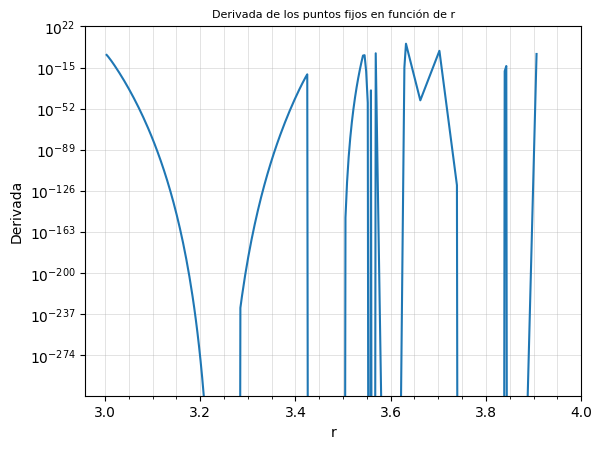

In [130]:
def derv(r_value,Xn):
    return r_value*(1-2*Xn)

r_values = []
orbit_values = []
derv_index = []
derv_fixed_values = np.array([])
b=0
for r in np.linspace(3.0, 4.0, 300):
    derivadas_values = []
    if r == 3.0:
        continue
    x = 0.6
    derivada_value = derv(r,x)
    for i in range(700): # Converger
        derivadas_values.append(derivada_value)
        x = logistic_map(r, x)
        derivada_value = derivada_value*derv(r,x)
        if i > 500:
            r_values.append(r)
            orbit_values.append(x)
    if periodos_logistic[b] != "Caos":
        # for _ in range(periodos_logistic[b]):
        derv_index.append(r)
        derv_fixed_values = np.concatenate((derv_fixed_values,np.array(derivadas_values[-1:])))
    b +=1
    
plt.plot(derv_index, np.array(derv_fixed_values))
# plt.ylim(-0.25e-400,0.25e-400)
plt.yscale('log')
plt.ylabel('Derivada')
plt.title('Derivada de los puntos fijos en función de r',fontsize=8)
plt.xlabel('r')
caotico = np.load('logistic_map/regimen_caotico.npy')
# plt.plot(caotico, color='brown')
major_ticks_x = np.linspace(3, 4, 6)  # 0.0, 0.2, ..., 1.0
minor_ticks_x = np.linspace(3, 4, 21)  # Ticks secundarios
# print(np.array(derv_index)[np.where(np.array(derv_fixed_values) == min(derv_fixed_values[:120]))])
# Configurar los ticks del eje X en ax1
plt.xticks(major_ticks_x)  # Solo etiquetar los ticks principales
plt.xticks(minor_ticks_x, minor=True)  # Agregar ticks menores sin etiquetas

# Activar la cuadrícula en ax1
plt.grid(which='major', linestyle='-', linewidth=0.5, alpha=0.5)  # Para ticks principales
plt.grid(which='minor', linestyle='-', linewidth=0.5, alpha=0.5)  # Para ticks menores      
# print(np.array(derv_fixed_values)[np.where(np.array(derv_index) == 3.20401338)])
derv_fixed_values

In [102]:
ff = [2,2,5,7,9,5,5,7,8]
np.array(ff[-3:])*10

array([50, 70, 80])

Dinámica simbólica
3.0033444816053514
3.0066889632107023
3.0100334448160537
3.0133779264214047
3.016722408026756
3.020066889632107
3.0234113712374584
3.0267558528428093
3.0301003344481607
3.0334448160535117
3.036789297658863
3.040133779264214
3.0434782608695654
3.0468227424749164
3.0501672240802677
3.0535117056856187
3.05685618729097
3.060200668896321
3.0635451505016724
3.0668896321070234
3.0702341137123748
3.0735785953177257
3.076923076923077
3.080267558528428
3.0836120401337794
3.0869565217391304
3.0903010033444818
3.0936454849498327
3.096989966555184
3.100334448160535
3.1036789297658864
3.1070234113712374
3.1103678929765888
3.1137123745819397
3.117056856187291
3.120401337792642
3.1237458193979935
3.1270903010033444
3.130434782608696
3.1337792642140467
3.137123745819398
3.140468227424749
3.1438127090301005
3.1471571906354514
3.150501672240803
3.1538461538461537
3.157190635451505
3.160535117056856
3.1638795986622075
3.1672240802675584
3.17056856187291
3.1739130434782608
3.177257525083

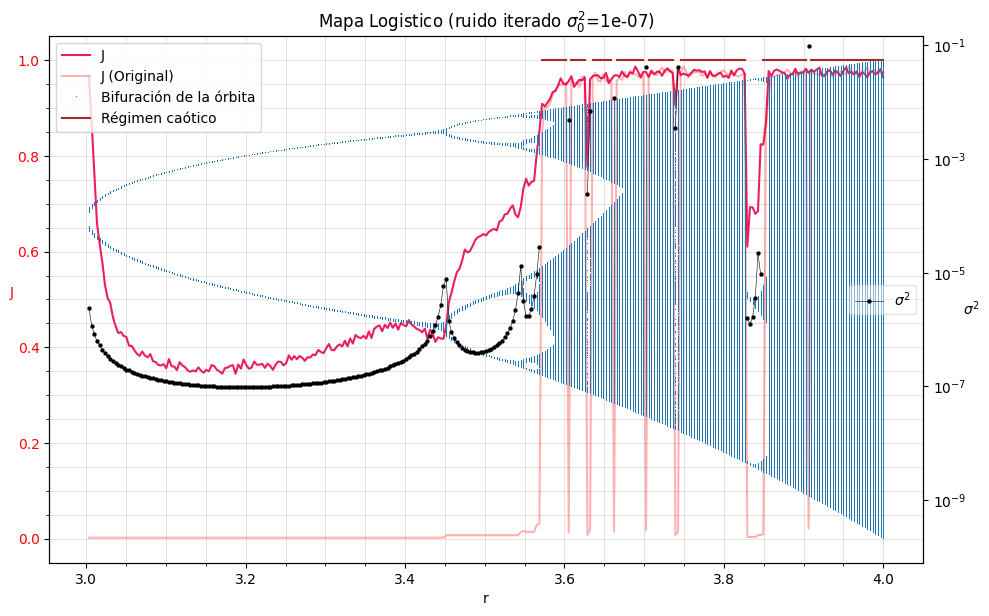

Correlación J-Jruido: 0.8898380306061929
Correlación de Spearman: 0.8898380306061929


In [140]:
"""interpolacion despues de dinamica simbolica"""
"""CON VARIANZA FUNCIONAL"""

def logistic_map(r, x):
    return r * x * (1 - x)

def plot_orbit_diagram(ruido,num_partitions,discreto,interpolacion, size,graficar, r_min = 3.0, r_max = 4.0, num_points_per_r=300,
 num_iterations_discard=4000, num_iterations_display=35000):
    if discreto == "no" and interpolacion == "si": 
        print("Haz seleccionado interpolación a los datos continuos, eso no tiene caso")
        return 1,2

    if interpolacion == "si":
        print("Interpolación")
    
    r_values = []
    orbit_values = []
    
    for r in np.linspace(r_min, r_max, num_points_per_r):
        if r == 3.0:
            continue
        x = 0.6
        ruidos = [1e-10,1e-8,1e-7,1e-4,1e-5,1e-6]
        colores = ['gray','#2ECC71','purple','#E91E63','#1ABC9C', '#FFD700']

        for _ in range(num_iterations_discard): # Converger
            x = np.clip(x, 0.0, 1.0)
            x = logistic_map(r, x) + generar_uniforme_centrada(1, ruido)[0]
        for _ in range(num_iterations_display):
            x = np.clip(x, 0.0, 1.0)
            x = logistic_map(r, x) + generar_uniforme_centrada(1, ruido)[0]
            r_values.append(r)
            orbit_values.append(x)
        
    #A partir de aqui, orbita continua de logistica completada
    if discreto == "si":
        print('Dinámica simbólica')
        # orbit_values = discretizar(orbit_values, num_partitions )
        
    a = 0
    b = 0
    J_values=[]
    J_index=[]
    # caotico = []
    varianzas=[]
    lyapunov_values = []
    derivadas_x,derivadas_y = [],[]
    
    r_values_interp = []
    orbit_values_interp = np.array([])
    ti, to = True, True
    for i in range(0, len(r_values) - 1):
        if r_values[i] != r_values[i+1]:
            print(r_values[i])
            r_single_orbit = orbit_values[a:i+1]
            a = i+1
            if interpolacion == 'si':
                x = np.arange(len(r_single_orbit))
                x_new, data_interp = interpolador(r_single_orbit, 'lineal', 15)
                # data_interp = interpolador_estocastico(data_interp, 3)
                # data_interp = r_single_orbit
                # random_array = generar_uniforme_centrada(num_iterations_display,ruido)
                # data_interp = data_interp + random_array
                r_values_interp = r_values_interp + [r_values[i]]*len(data_interp)
                orbit_values_interp = np.concatenate((orbit_values_interp, data_interp))

                r_single_orbit = data_interp
            var = var_per_state(r_single_orbit, periodos_logistic[b])
            if var == "Caos":
                varianzas.append(np.nan)
            else:
                varianzas.append( np.sum(np.array(var))/periodos_logistic[b])
            # lyapunov = lyapunov_exponent_from_orbit(r_single_orbit, r_values[i])
            # lyapunov_values.append(lyapunov)
            J, angulos = J_univariante(r_single_orbit, 1, False)
            J_values.append(J)
            J_index.append(r_values[i])
            from functools import reduce
            def derv(r_values,r_single_orbit,periodos_logistic):
                dervs = [r_values*(1-2*r_single_orbit[i]) for i in range(periodos_logistic)]
                return reduce(lambda x, y: x * y, dervs)
            # if var != "Caos":
            #     for l in range(periodos_logistic[b]):
            #         derivadas_x.append(r_values[i])
            #         derivadas_y.append(derv(r_values[i],r_single_orbit,l+1))
            b += 1


    
    #ultimo valor de r
    lyapunov = lyapunov_exponent_from_orbit(orbit_values[a:], r_values[len(r_values) - 1])  
    lyapunov_values.append(lyapunov)
    r_single_orbit = orbit_values[a:]
    if interpolacion == 'si':
        x = np.arange(len(orbit_values[a:]))
        x_new, data_interp = interpolador(orbit_values[a:], 'lineal', 15)
        # data_interp = interpolador_estocastico(data_interp, 3)
        # data_interp = orbit_values[a:]
        # data_interp = data_interp + random_array
        r_values_interp = r_values_interp + [r_values[i]]*len(data_interp)
        orbit_values_interp = np.concatenate((orbit_values_interp, data_interp))
        r_single_orbit = data_interp
    
    J = J_univariante(r_single_orbit, 1, False)[0]
    J_values.append(J)
    varianzas.append(np.nan)
    J_index.append(r_values[len(r_values) - 1])
    caotico = np.load('logistic_map/regimen_caotico.npy')
    # J_values = np.load('logistic_map/ruidos_promedios_iterado/J_por_ruido_'+str(ruido)+'.npy')
    varianzas = np.load('logistic_map/ruidos_promedios_iterado/varianza_por_ruido_'+str(ruido)+'.npy')
    # J_values = np.mean(J_values, axis=0)
    varianzas = np.mean(varianzas, axis = 0)
    # print(np.linspace(r_min, r_max, num_points_per_r)[np.argmin(varianzas[:135])])
    #A partir de aqui, lyapunob y J fueron calculados
    J_continuo = np.load('logistic_map\J_OG_muchosdatos.npy')
    # J_continuo = np.load('logistic_map/j_logistic_continuo.npy')

    if graficar == True:
        fig, ax1 = plt.subplots(figsize=(10,6))
        
        if discreto == "no":
            color = "red"
        elif discreto == "si":
            color = '#E91E63'
    
        ax1.plot(J_index, J_values, color=color, label='J' , alpha = 1)
        if discreto == "si":
            ax1.plot(J_index, J_continuo, 'red',label='J (Original)', alpha = 0.3)
            if interpolacion == "si":
                ax1.plot(r_values_interp, orbit_values_interp, ',', label=f'Bifuración de la órbita (+ ruido aditivo)', alpha=0.5)
            else: 
                ax1.plot(r_values, orbit_values, ',', label=f'Bifuración de la órbita', alpha=1)
        if discreto == "no":
            ax1.plot(r_values, orbit_values, ',', label='Bifurcación de la órbita', alpha=1)
        ax1.set_xlabel('r')
        ax1.set_ylabel('J', color='r', rotation = 360)
        ax1.tick_params(axis='y', labelcolor='r')
        # ax1.set_ylim(0,1)
        ax1.plot(J_index, np.array(caotico), color ='brown',linestyle='-', label = 'Régimen caótico')
        ax1.legend(loc = 'upper left')
        major_ticks_x = np.linspace(3, 4, 6)  # 0.0, 0.2, ..., 1.0
        minor_ticks_x = np.linspace(3, 4, 21)  # Ticks secundarios

        major_ticks_y = np.linspace(0, 1, 6)  # -1, -0.5, 0, 0.5, 1.0
        minor_ticks_y = np.linspace(0, 1, 21)  # Ticks secundarios

        # Configurar los ticks del eje X en ax1
        ax1.set_xticks(major_ticks_x)  # Solo etiquetar los ticks principales
        ax1.set_xticks(minor_ticks_x, minor=True)  # Agregar ticks menores sin etiquetas

        # Configurar los ticks del eje Y en ax1
        ax1.set_yticks(major_ticks_y)  # Solo etiquetar los ticks principales
        ax1.set_yticks(minor_ticks_y, minor=True)  # Agregar ticks menores sin etiquetas

        # Activar la cuadrícula en ax1
        ax1.grid(which='major', linestyle='-', linewidth=0.5, alpha=0.5)  # Para ticks principales
        ax1.grid(which='minor', linestyle='-', linewidth=0.5, alpha=0.5)  # Para ticks menores      

        if discreto == "no":
            ax2 = ax1.twinx()
            ax2.axhline(y=0, color='black', linestyle='--', alpha =0.55)
            ax2.plot(J_index, lyapunov_values, 'black', label = 'λ')
            ax2.set_ylabel('λ', color='black', rotation = 360)
            ax2.tick_params(axis='y', labelcolor='black')
            ax2.legend(loc='center right',framealpha=0.5)

        if discreto == "si" and True:
            ax2 = ax1.twinx() #[round(var*3, 8) if not np.isnan(var) else np.nan for var in varianzas]
            ax2.plot(J_index, varianzas, color ='black',ls='-',lw=0.4,marker='.',mew=0.1, label = r'$\sigma^2$')
            ax2.set_ylabel(r'$\sigma^2$', color='black', rotation = 360)
            # ax2.set_ylabel('P', color='black', rotation = 360)
            ax2.tick_params(axis='y', labelcolor='black')
            ax2.legend(loc='center right',framealpha=0.5)
            ######################
            ax2.set_yscale('log')
            if 1.5*max(varianzas) > 0.1:
                ax2.set_ylim(0.8e-10, 1.5*max(varianzas))
            else:
                ax2.set_ylim(0.8e-10, 0.1)
            # ax2.set_xlim(3.7,3.8)
            # ax2.set_ylim(0,np.max(varianzas[:170]))
            #####################

        fig.tight_layout()  
        # plt.title(f'Logistic Map (Discret ={discreto}, interp= {interpolacion})')
        # plt.title(f'Mapa Logístico con discretización en el eje y ({num_partitions} Particiones)')
        plt.title(r'Mapa Logistico (ruido iterado $\sigma_0^2$='+f'{ruido})')
        # plt.title('Mapa Logístico')
        # fig.savefig("logistic_map\logistic_ruido_iterado\logistic_"+str(ruido)+".png")
        plt.show()

        # plt.plot(derivadas_x,derivadas_y,',',color='red')
        # plt.ylim(-4,2)
        # plt.show()
    correlacion, p_valor = spearmanr(J_values, J_continuo)
    print(f'Correlación J-Jruido: {correlacion}')
    # correlacion, p_valor = spearmanr(J_values[~np.isnan(varianzas)], varianzas[~np.isnan(varianzas)])
    # print(f'Correlación de Jruido-varianza: {correlacion}')
    # np.save("varianzas_OG.npy", np.array(varianzas, dtype=object))
    if interpolacion == 'no':
        return J_index, J_values, r_values, orbit_values, lyapunov_values
    else:
        return J_index, J_values, r_values_interp, orbit_values_interp, lyapunov_values 


J_continuo = np.load('logistic_map\J_OG_muchosdatos.npy')
# J_continuo = np.load('logistic_map/j_logistic_continuo.npy')

# for ruido in [1e-10,1e-8, 1e-7,1e-6,1e-5,1e-4,1e-5,2e-5,3e-5,4e-5,5e-5,1e-3,1e-2]:
for ruido in [1e-7]:
    J_index, J_values, r_values, orbit_values, lyapunov_values = plot_orbit_diagram(ruido,15,"si","no", 20 ,True)
# J_index, J_values, r_values, orbit_values, lyapunov_values_continuo = plot_orbit_diagram(50,"no", "no", 20 ,True)


# Calcular correlación de Spearman
correlacion, p_valor = spearmanr(J_values, J_continuo)

print(f'Correlación de Spearman: {correlacion}')

In [21]:
def detect_per(Xn, tolerancia=1e-6, max_periodo=100):
    """
    Detecta si Xn está en un régimen periódico y calcula la varianza por punto fijo.
    Si el sistema es caótico, devuelve una lista con una varianza igual a 1.
    
    Parámetros:
        Xn (array): Secuencia del mapa logístico.
        tolerancia (float): Tolerancia para determinar igualdad de puntos.
        max_periodo (int): Máximo periodo a buscar.
    
    Retorna:
        dict: Contiene información sobre el régimen y las varianzas calculadas.
    """
    n = len(Xn)
    for periodo in range(1, max_periodo + 1):
        es_periodico = True
        for i in range(n - periodo):
            if abs(Xn[i] - Xn[i + periodo]) > tolerancia:
                es_periodico = False
                break
        if es_periodico:
            # Calcular las varianzas para cada punto fijo del ciclo
            puntos_fijos = [Xn[i::periodo] for i in range(periodo)]
            varianzas = [np.var(punto_fijo) for punto_fijo in puntos_fijos]
            # print(f"regimen: periodico-{periodo}, varianzas: {varianzas}")
            return periodo
    
    # Si no se encuentra un periodo, considerar el régimen caótico
    # print("regimen: caotico, varianzas: 1")
    return "Caos"

# Ejemplo de uso
Xn = [0.1, 0.4, 0.1, 0.4]*100  # Ejemplo de periodo-3
resultado = detect_per(Xn)
print(resultado)

2


In [22]:
def var_per_state(Xn,N):
    """
    Divide Xn en N arrays, donde cada uno contiene un punto fijo del periodo.
    
    Parámetros:
        Xn (array): Secuencia del mapa logístico.
        N (int): Número de periodo.
    
    Retorna:
        list: Lista de N arrays, cada uno con un punto fijo del ciclo.
    """
    # N = detect_per(Xn)
    # print(N)
    if N == "Caos":
        return "Caos"
    if N <= 0:
        raise ValueError("El número de periodo debe ser mayor que 0.")
    if len(Xn) < N:
        raise ValueError("El tamaño del array es menor que el número de periodo.")
    
    puntos_fijos = [Xn[i::N] for i in range(N)]
    # for p in puntos_fijos:
        # print(p[:20])
    varianza = [np.var(arr) for arr in puntos_fijos]
    # print(np.array(varianza) - [8.011868568650901e-32, 1.5407439555097887e-32])

        # return np.sum(varianza)/len(varianza)
    return varianza

# Ejemplo de uso
Xn = [0.1, 0.4, 0.6, 0.1, 0.4, 0.6, 0.1, 0.4, 0.6]  # Ejemplo de periodo-3
# N = 3
var = var_per_state(Xn,2)
print(var)
var = np.array(var)-[0.0005674823316511015, 0.0005610965990578426]
print(np.array(var))
print(np.sum(var)/2)
#3.419439112363466e-07


[0.050399999999999986, 0.03187500000000001]
[0.04983252 0.0313139 ]
0.04057321053464552


In [627]:
"""logistic ruido multiple
NO EDITAR HASTA CORRER LOS PROMEDIOS
"""


def logistic_map(r, x):
    return r * x * (1 - x)

def plot_orbit_diagram(num_partitions,discreto,interpolacion, size,graficar, r_min = 3.0, r_max = 4.0, num_points_per_r=300,
 num_iterations_discard=3000, num_iterations_display=2000):
    if discreto == "no" and interpolacion == "si": 
        print("Haz seleccionado interpolación a los datos continuos, eso no tiene caso")
        return 1,2

    if interpolacion == "si":
        print("Interpolación")

    ruidos = [5e-5,1e-3,1e-2]
    colores = ['gray','#2ECC71','purple','#E91E63','#1ABC9C', '#FFD700']
    J_por_ruido = []
    for ruido in ruidos:   
        Jss = []
        vss = []
        for _ in range(100): 

            r_values = []
            orbit_values = []

            for r in np.linspace(r_min, r_max, num_points_per_r):
                
                x = 0.6
                if r == 3.0:
                    continue
                for _ in range(num_iterations_discard): # Converger
                    x = np.clip(x, 0.0, 1.0)
                    x = logistic_map(r, x) + generar_uniforme_centrada(1, ruido)[0]
                
                for _ in range(num_iterations_display):
                    x = np.clip(x, 0.0, 1.0)
                    x = logistic_map(r, x) + generar_uniforme_centrada(1, ruido)[0]
                    r_values.append(r)
                    orbit_values.append(x)
                
            #A partir de aqui, orbita continua de logistica completada
            if discreto == "si":
                print('Dinámica simbólica')
                # orbit_values = discretizar(orbit_values, num_partitions )

            a = 0
            b = 0
            J_values=[]
            J_index=[]
            lyapunov_values = []
            varianzas = []
            
            r_values_interp = []
            orbit_values_interp = np.array([])
            random_array = generar_uniforme_centrada(num_iterations_display,ruido)
            ti, to = True, True
            for i in range(0, len(r_values) - 1):
                if r_values[i] != r_values[i+1]:
                    r_single_orbit = orbit_values[a:i+1]
                    a = i+1
                    
                    if interpolacion == 'si':
                        x = np.arange(len(r_single_orbit))
                        # x_new, data_interp = interpolador(r_single_orbit, 'lineal', 15)
                        # data_interp = interpolador_estocastico(data_interp, 3)
                        data_interp = r_single_orbit
                        random_array = generar_uniforme_centrada(num_iterations_display,ruido)
                        data_interp = data_interp + random_array
                        r_values_interp = r_values_interp + [r_values[i]]*len(data_interp)
                        orbit_values_interp = np.concatenate((orbit_values_interp, data_interp))

                        r_single_orbit = data_interp

                    var = var_per_state(r_single_orbit, periodos_logistic[b])
                    if var == "Caos":
                        varianzas.append(np.nan)
                    else:
                        varianzas.append( np.sum(np.array(var))/periodos_logistic[b] )
                    # lyapunov = lyapunov_exponent_from_orbit(r_single_orbit, r_values[i])
                    # lyapunov_values.append(lyapunov)
                    J, angulos = J_univariante(r_single_orbit, 1, False)
                    # if r_values[i] > 2.8 and ti == True:
                    #     plt.plot(np.angle(np.fft.rfft(r_single_orbit)), ',')
                    #     plt.show()
                    #     plt.plot(r_single_orbit[:200], ',')
                    #     plt.show()
                    #     ti = False
                    #     plt.show()
                    # if J < 0.4 and to == True:
                    #     plt.plot(np.angle(np.fft.rfft(r_single_orbit)), ',')
                    #     plt.show()
                    #     print(r_values[i])
                    #     plt.plot(r_single_orbit, ',')
                    #     plt.show()
                    #     graficar_angulos_en_circulo(angulos)
                    #     plt.show()
                    #     to = False
                    J_values.append(J)
                    J_index.append(r_values[i])

                    b += 1
            
            #ultimo valor de r
            # lyapunov = lyapunov_exponent_from_orbit(orbit_values[a:], r_values[len(r_values) - 1])  
            # lyapunov_values.append(lyapunov)
            if interpolacion == 'si':
                x = np.arange(len(orbit_values[a:]))
                # x_new, data_interp = interpolador(orbit_values[a:], 'lineal', 15)
                # data_interp = interpolador_estocastico(data_interp, 3)
                data_interp = orbit_values[a:]
                random_array= generar_uniforme_centrada(num_iterations_display,ruido)
                data_interp = data_interp + random_array
                r_values_interp = r_values_interp + [r_values[i]]*len(data_interp)
                orbit_values_interp = np.concatenate((orbit_values_interp, data_interp))
                r_single_orbit = data_interp

            J = J_univariante(r_single_orbit, 1, False)[0]
            J_values.append(J)
            varianzas.append(np.nan)
            J_index.append(r_values[len(r_values) - 1])
            Jss.append(J_values)
            vss.append(varianzas)
        np.save('logistic_map/ruidos_promedios_iterado/varianza_por_ruido_'+ str(ruido) + '.npy', vss)
        np.save('logistic_map/ruidos_promedios_iterado/J_por_ruido_'+ str(ruido) + '.npy', Jss)
        J_por_ruido.append(np.mean(Jss,axis=0))
        print(ruido)

    #A partir de aqui, lyapunob y J fueron calculados

    J_continuo = np.load('logistic_map/j_logistic_continuo.npy')
    
    if graficar == True:
        fig, ax1 = plt.subplots(figsize=(10,6))
        
        if discreto == "no":
            color = "red"
        elif discreto == "si":
            color = "gray"
        for i,ruido in enumerate(ruidos):
            ax1.plot(J_index, J_por_ruido[i], color=colores[i] , alpha = 1)
            ax1.annotate(f'Varianza = {ruido}', xy=(J_index[len(J_index)//4], J_por_ruido[i][len(J_index)//4]), xytext=(10, J_por_ruido[i][-1]),
                         textcoords='offset points', ha='left', va='center')

        if discreto == "si":
            ax1.plot(J_index, J_continuo, 'red',label='J (Original)', alpha = 0.3)
            if interpolacion == "si":
                ax1.plot(r_values_interp, orbit_values_interp, ',', label=f'Bifuración de la órbita (+ ruido)', alpha=0.5)
            else: 
                ax1.plot(r_values, orbit_values, ',', label='Bifuración de la órbita + ruido', alpha=1)
        if discreto == "no":
            ax1.plot(r_values, orbit_values, ',', label='Bifurcación de la órbita', alpha=1)
        ax1.set_xlabel('r')
        ax1.set_ylabel('J', color='r', rotation = 360)
        ax1.tick_params(axis='y', labelcolor='r')
        # ax1.set_ylim(0,1)
        ax1.legend(loc = 'upper left')
        

        if discreto == "no":
            ax2 = ax1.twinx()
            ax2.axhline(y=0, color='black', linestyle='--', alpha =0.55)
            ax2.plot(J_index, lyapunov_values, 'black', label = 'λ')
            ax2.set_ylabel('λ', color='black', rotation = 360)
            ax2.tick_params(axis='y', labelcolor='black')
            ax2.legend(loc='center right',framealpha=0.5)
        
        fig.tight_layout()  
        major_ticks_x = np.linspace(3, 4, 6)  # 0.0, 0.2, ..., 1.0
        minor_ticks_x = np.linspace(3, 4, 21)  # Ticks secundarios

        major_ticks_y = np.linspace(0, 1, 6)  # -1, -0.5, 0, 0.5, 1.0
        minor_ticks_y = np.linspace(0, 1, 6)  # Ticks secundarios

        # Configurar los ticks del eje X
        plt.xticks(major_ticks_x)  # Solo etiquetar los ticks principales
        plt.gca().set_xticks(minor_ticks_x, minor=True)  # Agregar ticks menores sin etiquetas

        # Configurar los ticks del eje Y
        plt.yticks(major_ticks_y)  # Solo etiquetar los ticks principales
        plt.gca().set_yticks(minor_ticks_y, minor=True)  # Agregar ticks menores sin etiquetas

        # Activar la cuadrícula
        plt.grid(which='major', linestyle='-', linewidth=0.5, alpha=0.5)  # Para ticks principales
        plt.grid(which='minor', linestyle='-', linewidth=0.5, alpha=0.5)  # Para ticks secundarios

        # plt.title(f'Logistic Map (Discret ={discreto}, interp= {interpolacion})')
        # plt.title(f'Mapa Logístico con discretización en el eje y ({num_partitions} Particiones)')
        plt.title(f'Mapa Logistica (Con ruido iterado)')
        plt.show()

    
    if interpolacion == 'no':
        return J_index, J_values, r_values, orbit_values, lyapunov_values
    else:
        return J_index, J_values, r_values_interp, orbit_values_interp, lyapunov_values 


with open('logistic_map/lyapunov_continuo.txt', 'r') as f:
        lyapunov_continuo = [float(line.strip()) for line in f]

J_continuo = np.load('logistic_map/j_logistic_continuo.npy')

J_index, J_values, r_values, orbit_values, lyapunov_values = plot_orbit_diagram(15,"si", "no", 20 ,False)
# J_index, J_values, r_values, orbit_values, lyapunov_values_continuo = plot_orbit_diagram(50,"no", "no", 20 ,True)


# Calcular correlación de Spearman
correlacion, p_valor = spearmanr(J_values, J_continuo)

print(f'Correlación de Spearman: {correlacion}')

Dinámica simbólica
Dinámica simbólica
Dinámica simbólica
Dinámica simbólica
Dinámica simbólica
Dinámica simbólica
Dinámica simbólica
Dinámica simbólica
Dinámica simbólica
Dinámica simbólica
Dinámica simbólica
Dinámica simbólica
Dinámica simbólica
Dinámica simbólica
Dinámica simbólica
Dinámica simbólica
Dinámica simbólica
Dinámica simbólica
Dinámica simbólica
Dinámica simbólica
Dinámica simbólica
Dinámica simbólica
Dinámica simbólica
Dinámica simbólica
Dinámica simbólica
Dinámica simbólica
Dinámica simbólica
Dinámica simbólica
Dinámica simbólica
Dinámica simbólica
Dinámica simbólica
Dinámica simbólica
Dinámica simbólica
Dinámica simbólica
Dinámica simbólica
Dinámica simbólica
Dinámica simbólica
Dinámica simbólica
Dinámica simbólica
Dinámica simbólica
Dinámica simbólica
Dinámica simbólica
Dinámica simbólica
Dinámica simbólica
Dinámica simbólica
Dinámica simbólica
Dinámica simbólica
Dinámica simbólica
Dinámica simbólica
Dinámica simbólica
Dinámica simbólica
Dinámica simbólica
Dinámica sim

Text(0.5, 1.0, 'Simulación de periodo-2 con incremento de separación d')

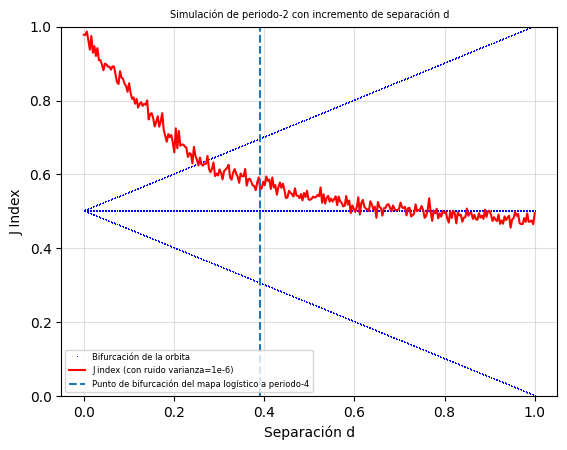

In [175]:
Jss= np.load('logistic_map/periodos_simulados/J_periodo2_simulado_1e-6.npy')
# Jss=[]
# print(np.shape(Jss))
Js=[]
x1 = 0.5
d = 0.07 
for d in np.linspace(0.0001,0.5,300):
    random = generar_uniforme_centrada(3999, 1e-6)
    array = interpolador(np.array([x1-d,x1+d]*1000),'lineal',1)[1] + random
    x_index = [d*2]*len(array)
    Js.append([J_univariante(array,1,False)[0]])
    plt.plot(x_index,array,',',color='blue')

plt.plot(x_index,array,',',color='blue',label='Bifurcación de la orbita')
plt.plot(np.linspace(0.0001,0.5,300)*2,Js,color='red',label='J index (con ruido varianza=1e-6)')
# plt.plot(np.linspace(0.0001,0.5,300)*2,np.mean(Jss,axis=0),color='red',label='J index (con ruido varianza=1e-6)')
plt.axvline(x = 0.39,linestyle='--', label = 'Punto de bifurcación del mapa logístico a periodo-4')
plt.xlabel('Separación d')
plt.ylabel('J Index')
plt.grid(alpha=0.4)
plt.ylim(0,1.0)
plt.legend(fontsize=6)
plt.title('Simulación de periodo-2 con incremento de separación d',fontsize=7)

In [122]:
import itertools

def generate_combinations(x1, x2, d1, d2):
    """
    Genera todas las combinaciones posibles del array [x2-d2/2, x1+d1/2, x2+d2/2, x1-d1/2].
    Cada elemento puede tomar dos valores:
    - Mantenerse como está.
    - Ser modificado según la suma/resta con su término correspondiente.
    
    Parámetros:
    x1, x2, d1, d2 : números (float o int)

    Retorna:
    Lista con todas las combinaciones posibles.
    """
    # Generar todas las opciones para cada término
    options = [
        [x2 - d2 / 2, x2 - d2],  # Para x2 - d2/2
        [x1 + d1 / 2, x1+d1],  # Para x1 + d1/2
        [x2 + d2 / 2, x2+d2],  # Para x2 + d2/2
        [x1 - d1 / 2, x1-d1]   # Para x1 - d1/2
    ]
    
    # Generar todas las combinaciones posibles
    combinations = list(itertools.product(*options))
    return combinations

# Ejemplo de uso
x1, x2, d1, d2 = 2, 3, 1, 4
print([x2-d2/2,x1+d1/2,x2+d2/2,x1-d1/2])
combinations = generate_combinations(x1, x2, d1, d2)
combinations 
combinations

[1.0, 2.5, 5.0, 1.5]


[(1.0, 2.5, 5.0, 1.5),
 (1.0, 2.5, 5.0, 1),
 (1.0, 2.5, 7, 1.5),
 (1.0, 2.5, 7, 1),
 (1.0, 3, 5.0, 1.5),
 (1.0, 3, 5.0, 1),
 (1.0, 3, 7, 1.5),
 (1.0, 3, 7, 1),
 (-1, 2.5, 5.0, 1.5),
 (-1, 2.5, 5.0, 1),
 (-1, 2.5, 7, 1.5),
 (-1, 2.5, 7, 1),
 (-1, 3, 5.0, 1.5),
 (-1, 3, 5.0, 1),
 (-1, 3, 7, 1.5),
 (-1, 3, 7, 1)]

27


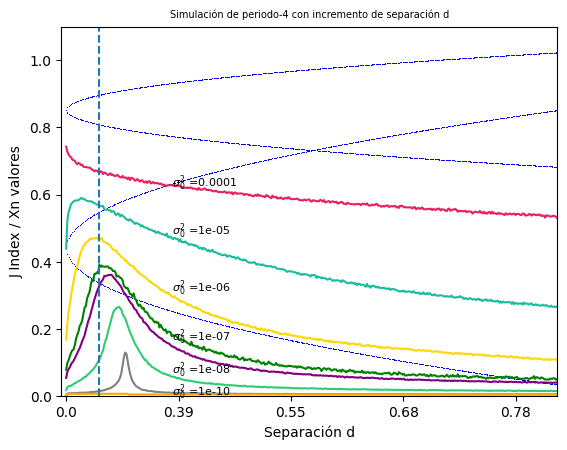

In [193]:
"""NO EDITAR HASTA CORRER PROMEDIOS"""
ruidos = [1e-10,1e-8,1e-7,1e-4,1e-5,1e-6]
for ruido in [1e-8]:
    # Jss= np.load('logistic_map/periodos_simulados/J_periodo4_simulado_1e-6.npy')
    x1 = 0.44
    x2 = 0.85
    d_1 = 0.2431*np.sqrt(np.linspace(0,15.5,550))
    d_2 = 0.1013*np.sqrt(np.linspace(0,15.5,550)) #0,15.5,550
    ruidos = [1e-10,1e-8,1e-7,1e-4,1e-5,1e-6]
    colores = ['gray','#2ECC71','purple','#E91E63','#1ABC9C', '#FFD700']
    Js=[]
    Js_ruido=[]
    # ruido = 1e-7
    for i,(d1,d2) in enumerate(zip(d_1,d_2)):
        # array = list(generate_combinations(x1, x2, d1, d2)[q])*500
        array = [x2 -d2/2,x1 + d1/2,x2 + d2/2,x1 - d1/2]*10000
        random = generar_uniforme_centrada(40000, ruido)
        array_ruido = array + random
        x_index = [i]*len(array)
        # if d1 > 0.12:
        #     print(i)
        #     print('d1',d1)
        #     print('d2',d2)
        #     print((x2-d2/2)-(x1+d1/2))
        #     print([x2-d2/2,x1+d1/2,x2+d2/2,x1-d1/2])
        # Js.append(J_univariante(array,1,False)[0])
        Js_ruido.append(J_univariante(array_ruido,1,False)[0])
        # if i == 0 or i == 48 or i == 500:
        #     # print(array[0]-array[1],array[1]-array[2],array[2]-array[3],array[3]-array[4])
        
        #     plt.plot(np.angle(np.fft.rfft(array_ruido)),'.')
        #     plt.show()
        plt.plot(x_index,array_ruido,',',color='blue',alpha=0.1)
    Js = np.load('logistic_map/periodos_simulados/J_periodo4_simulado_OG.npy')
    maxx = np.argmax(Js_ruido)
    print(maxx)
    plt.plot(Js_ruido,label=f'J (ruido varianza = {ruido})',color='green')
    Js_ruido = np.load('logistic_map/periodos_simulados/J_periodo4_simulado_'+ str(ruido) + '.npy')
    Js_ruido = np.mean(Js_ruido,axis=0)
    # plt.plot(Js_ruido,label=f'J (ruido varianza = {ruido})',color='red')
    for i,ruido in enumerate(ruidos):
        Js_ruido = np.load('logistic_map/periodos_simulados/J_periodo4_simulado_'+ str(ruido) + '.npy')
        Js_ruido = np.mean(Js_ruido,axis=0)
        plt.plot(Js_ruido, color=colores[i] , alpha = 1)
        plt.annotate(r'$\sigma_0^2$ ='+ f'{ruido}', xy=(75, Js_ruido[75]), xytext=(10, Js_ruido[-1]),
                        textcoords='offset points', ha='left', va='center',fontsize=8)
    plt.plot(x_index,array,',',color='blue',label='Bifurcación de la orbita',alpha=0.3)
    # plt.plot(np.mean(Jss,axis=0),label='J (ruido varianza = 1e-6)',color='red')
    plt.plot(Js,label='J (sin ruido)',color='orange')
    # print(Js_ruido[27])
    # x=9 mapa logis
    plt.axvline(x = maxx,linestyle='--', label = 'Bifurcación del mapa logístico en periodo-4 a un periodo-8')
    plt.xlabel('Separación d')
    plt.ylabel('J Index / Xn valores')
    plt.xticks(ticks=np.linspace(0,549,7), labels=np.round(0.2431*np.sqrt(np.linspace(0,15.5,7)), 2))
    plt.ylim(0,1.1)
    plt.xlim(-4,400)
    # plt.legend(fontsize=7,loc='upper left')
    plt.title('Simulación de periodo-4 con incremento de separación d',fontsize=7)
    plt.show()
# 0.23639426238989814 -0.33852121488643305 0.5836057376101018 -0.4814787851135669


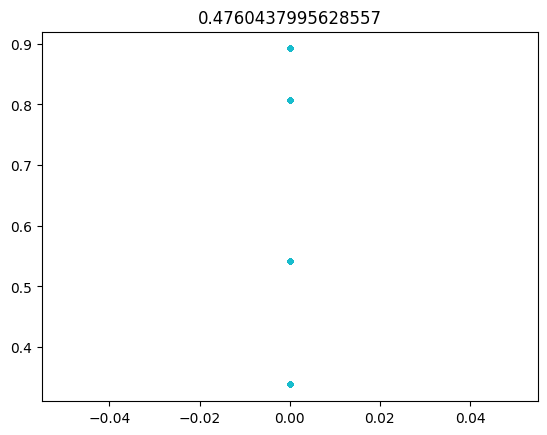

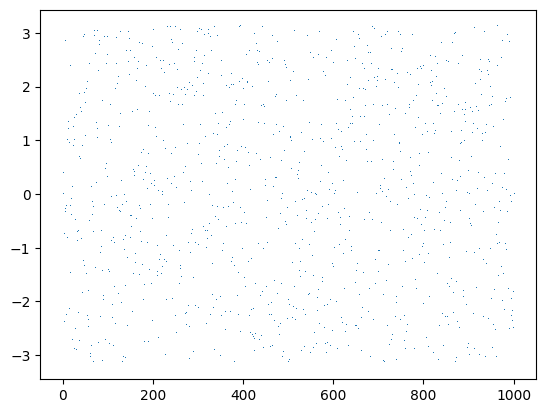

In [670]:
ge=[]
for _ in range(100):
    d1 = 0.2431*np.sqrt(0.7)
    d2 = 0.1013*np.sqrt(0.7)
    array = [x2-d2/2,x1+d1/2,x2+d2/2,x1-d1/2]*500
    plt.plot([0]*2000, array,'.')
    # print(array[:5])
    j=J_univariante(array+generar_uniforme_centrada(len(array),1e-6),1,False)[0]
    ge.append(j)
plt.title(np.mean(ge))
plt.show()
plt.plot(np.angle(np.fft.rfft(array+generar_uniforme_centrada(len(array),1e-6))),',')

# Ruido sumado
$X_{t+1} = X_{t}r (1 - X_{t}) $ \
$X'_{t+1} = X_{t+1}  + \eta_{t} $ \
$X'_{t+2} = X_{t+2} + \eta_{t+1}$ \
$X'_{t+3} = X_{t+3} + \eta_{t+2}$

# Ruido iterado
$X'_{t+1} = X_{t+1} + \eta_{t} $ \
$X'_{t+2} = X'_{t+1} + \eta_{t+1} $ \
$X'_{t+3} = X'_{t+2} + \eta_{t+2} $ 

Correlación de Spearman: 0.7703832264802941

In [13]:
"""Grafica  de corr vs M para lyapunov y J discretos
Grafica de corr vs M para lyapunov y J interpolados lineal y hermite 
Xn vs r 50 particiones J_original, J_discreta, lyapunov_discreto
Xn vs r 1500 particiones J_original, J_discreta, lypunov_discreto"""

'Grafica  '

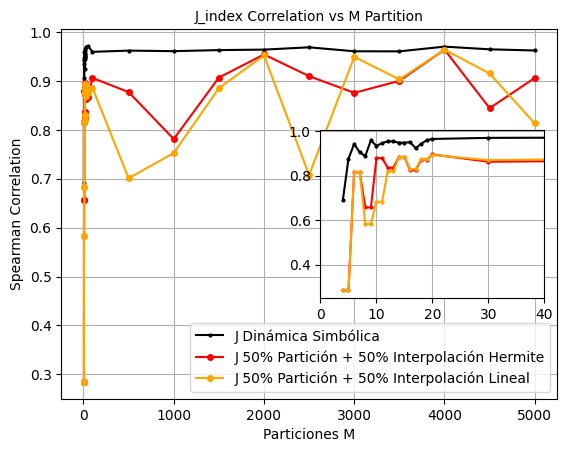

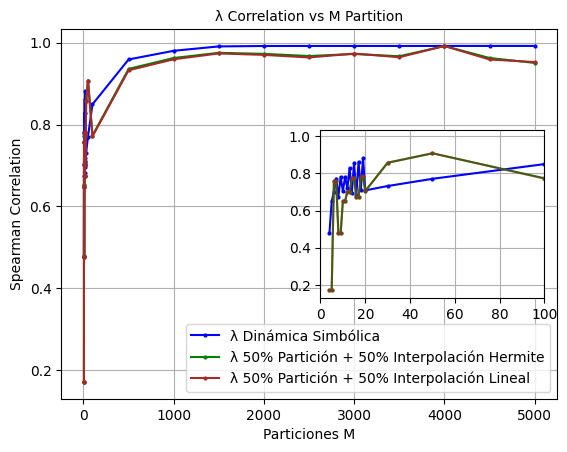

In [146]:
x = [4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19, 20, 30, 50,100, 500, 1000,1500,2000,2500, 3000,3500, 4000,4500, 5000]

# Crear la gráfica principal
fig, ax = plt.subplots()
ax.plot(x,corr_J_discret_list, label = 'J Dinámica Simbólica',markersize = 4, color = 'black', marker='.', linestyle='-')
ax.plot(x, corr_J_interp_herm, markersize = 4, label = 'J 50% Partición + 50% Interpolación Hermite', color = 'red', marker='o', linestyle='-')
ax.plot(x, corr_J_interp_lineal,markersize = 4, label = 'J 50% Partición + 50% Interpolación Lineal',color = 'orange', marker='o', linestyle='-')
# Crear la gráfica de zoom como un inset
ax_inset = fig.add_axes([0.53, 0.32, 0.35, 0.35])  # [left, bottom, width, height] en coordenadas normalizadas
ax_inset.plot(x,corr_J_discret_list, color='black',marker='.', linestyle='-', markersize = 4)
ax_inset.plot(x,corr_J_interp_herm, color='red',marker='.', linestyle='-', markersize = 4)
ax_inset.grid()
ax_inset.plot(x,corr_J_interp_lineal, color='orange', marker='.', linestyle='-', markersize = 4)
ax_inset.set_xlim(0, 40)
ax.set_xlabel('Particiones M')
ax.set_ylabel('Spearman Correlation')
ax.grid()
ax.set_title('J_index Correlation vs M Partition', fontsize=10)
ax.legend()
plt.show()

fig, ax = plt.subplots()
ax.plot(x,corr_lyapunov_discret_list, label = 'λ Dinámica Simbólica',color = 'blue',markersize = 4, marker='.', linestyle='-')
ax.plot(x, corr_lyapunov_interp_herm, label = 'λ 50% Partición + 50% Interpolación Hermite',color = 'green',markersize = 4, marker='.', linestyle='-')
ax.plot(x, corr_lyapunov_interp_lineal, label = 'λ 50% Partición + 50% Interpolación Lineal',color = 'brown',markersize = 4, marker='.', linestyle='-')
# Crear la gráfica de zoom como un inset
ax_inset = fig.add_axes([0.53, 0.32, 0.35, 0.35])  # [left, bottom, width, height] en coordenadas normalizadas
ax_inset.plot(x,corr_lyapunov_discret_list, color='blue',marker='.', linestyle='-', markersize = 4)
ax_inset.plot(x,corr_lyapunov_interp_herm, color='green',marker='.', linestyle='-', markersize = 4)
ax_inset.grid()
ax_inset.plot(x,corr_lyapunov_interp_lineal, color='brown',alpha = 0.5, marker='.', linestyle='-', markersize = 4)
ax_inset.set_xlim(0, 100)
ax.set_xlabel('Particiones M')
ax.set_ylabel('Spearman Correlation')
ax.grid()
ax.set_title('λ Correlation vs M Partition',fontsize=10)
ax.legend()
plt.show()